In [304]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

#from pipeline.python.retinotopy import fit_2d_rfs as fitrf
#from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
#from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python import utils as putils #.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D

import matplotlib.patches as patches

In [305]:
%matplotlib notebook

In [306]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

# Colors

In [307]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Dataset info

In [811]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = 'ROC' # 'nstds' #'ROC' #None
responsive_thr = 0.05 if responsive_test=='ROC' else 10.0 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

#### RF fit params
response_type = 'dff'
# fit_thr=0.5

#### Set outputdir for current analysis
#fit_desc = fitrf.get_fit_desc(response_type=response_type)
# outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
# if not os.path.exists(outdir):
#     os.makedirs(outdir)
# print("... saving output to base dir:\n%s" % outdir)


In [812]:
#### Create data ID for labeling figures with data-types

filter_by = 'first'
has_gratings=False
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = '%s_%s_%s_resptest-%s_respthr-%.2f' % (response_type, filter_by, g_str, responsive_test, responsive_thr)

In [813]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|dff_first_blobsonly_resptest-ROC_respthr-0.05


In [814]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [815]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [816]:
# Get blob metadata only - and only if have RFs
sdata_blobs = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        'blobs' in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)])
sdata_blobs[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


In [817]:
# Drop duplicates and whatnot fovs
blobmeta = aggr.get_blob_datasets(filter_by=filter_by, has_gratings=has_gratings, as_dict=True)
for k, v in blobmeta.items():
    print('%s: %i datasets' % (k, len(v)))

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [818]:
blobmeta

{'Li': ['20190605_JC090',
  '20190617_JC099',
  '20191018_JC113',
  '20191105_JC117',
  '20191111_JC120',
  '20190602_JC091',
  '20190606_JC091',
  '20190609_JC099',
  '20190502_JC076'],
 'Lm': ['20190525_JC084',
  '20190627_JC091',
  '20190618_JC097',
  '20190512_JC083',
  '20190504_JC078',
  '20190430_JC078',
  '20190506_JC080',
  '20190508_JC083'],
 'V1': ['20190522_JC084',
  '20190622_JC085',
  '20190613_JC097',
  '20190616_JC097',
  '20190617_JC097',
  '20191006_JC110',
  '20190420_JC076',
  '20190507_JC083']}

In [820]:
def melt_square_matrix(df, metric_name='value', add_values={}, include_diagonal=False):
    
    k = 0 if include_diagonal else 1
    df = df.where(np.triu(np.ones(df.shape), k=k).astype(np.bool))

    df = df.stack().reset_index()
    df.columns=['row', 'col', metric_name]
    
    if len(add_values) > 0:
        for k, v in add_values.items():
            df[k] = [v for _ in np.arange(0, df.shape[0])]
    
    return df

In [821]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples


# Load aggregate data

In [822]:
filter_str

'dff_first_blobsonly_resptest-ROC_respthr-0.05'

In [860]:
glob.glob(os.path.join(stats_dir, 'aggr_blobs_*%s*.pkl' % responsive_test))[-2:]
      

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_traces001_ROC-thr-0.05_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_traces001_ROC-thr-0.05_dff_baseline.pkl']

In [824]:
print(glob.glob(os.path.join(stats_dir, 'aggr_blobs_binnedtraces*.pkl')))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_binnedtraces_dff_unique_a_resptest-ROC_respthr-0.05.pkl', '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_binnedtraces.pkl']


In [859]:
#aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_*%s*.pkl' % responsive_test))[0]
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_*%s*.pkl' % responsive_test))[-2:][0]
print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_traces001_ROC-thr-0.05_dff_stimulus.pkl


In [586]:
glob.glob(os.path.join(stats_dir, 'aggr_blobs_*baseline.pkl'))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_traces001_nstds-thr-10.00_dff_baseline.pkl']

In [861]:
aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_*%s*.pkl' % responsive_test))[-2:][1]
print(aggr_baselines_dfile)
with open(aggr_baselines_dfile, 'rb') as f:
    BAS = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_traces001_ROC-thr-0.05_dff_baseline.pkl


In [33]:
aggr_binnedtraces_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_binnedtraces.pkl'))[0]
with open(aggr_binnedtraces_dfile, 'rb') as f:
    bindict = pkl.load(f)
BINNED = bindict['BINNED']

In [829]:
len(BAS.keys()), len(MEANS.keys())

(37, 37)

In [862]:
BAS[datakey].head()

,0,3,4,6,14,24,26,29,40,46,...,193,196,197,206,207,213,219,223,225,config
1,9.837810e-17,-3.170304e-16,-2.667619e-16,9.853229e-17,-3.546546e-17,-6.460881e-17,1.086322e-16,-4.764707e-17,-2.172259e-17,-1.042376e-16,...,1.634495e-17,-7.470876e-17,-8.496290e-17,-3.977528e-16,-4.903485e-17,9.683612e-17,-1.112536e-16,-2.652199e-16,-1.811822e-16,config043
2,-1.152627e-17,-9.506285e-17,-2.678413e-16,-6.723017e-17,-3.268990e-17,2.129662e-16,-2.561223e-16,2.128313e-16,1.575900e-16,7.278129e-17,...,-5.890350e-17,-3.441499e-17,4.132497e-17,-1.907425e-16,2.467162e-17,1.249001e-16,-4.487151e-17,-2.019989e-16,1.412450e-16,config042
3,-1.418618e-16,-1.156482e-17,-4.756997e-17,2.081668e-17,7.308968e-17,5.713023e-17,1.592091e-16,-1.517305e-16,1.128727e-16,-7.709882e-20,...,-5.011423e-17,-4.039978e-17,-1.387779e-16,2.312965e-18,-8.912624e-17,1.554312e-16,2.374644e-17,9.976587e-17,2.337636e-16,config050
4,8.897204e-17,-3.245860e-17,1.219703e-16,1.295260e-17,2.592062e-16,-1.431340e-16,3.628271e-16,7.709882e-19,-1.381611e-16,-2.047745e-16,...,2.706169e-17,8.349802e-17,-1.316848e-16,-5.242720e-17,8.635068e-18,-1.289092e-16,-7.324388e-17,2.257453e-16,-7.725302e-17,config017
5,1.448301e-16,-3.346474e-16,1.801028e-16,6.992863e-17,-1.387779e-16,1.047773e-16,5.797831e-17,-3.700743e-18,-3.090121e-16,2.155683e-16,...,-1.794090e-16,3.392348e-17,-5.042263e-17,-2.868076e-17,7.571104e-17,6.753857e-17,-3.113250e-16,-1.557396e-17,6.537980e-17,config044


In [863]:
MEANS[datakey].head()

,0,3,4,6,11,14,24,26,29,40,...,193,196,197,206,207,213,219,223,225,config
1,-0.014941,0.029436,0.042814,0.007642,0.010917,0.036700,-0.010796,-0.001756,0.036385,0.016011,...,0.000192,0.040647,0.001846,0.030502,0.033699,-0.057194,-0.016417,-0.011595,-0.025961,config043
2,-0.000745,0.004396,0.037649,-0.022220,0.005484,0.017604,0.006993,-0.031249,-0.014533,0.012749,...,0.015417,0.048468,-0.020069,-0.005748,0.003087,-0.012941,0.014659,0.000110,0.004790,config042
3,0.001740,0.014288,0.002055,0.027838,0.028606,0.014264,-0.010186,-0.001797,-0.049257,0.013542,...,0.001659,-0.009952,0.011963,0.014843,0.025288,0.005230,-0.006943,0.003114,0.002517,config050
4,0.000880,0.015532,0.029061,-0.004349,0.017690,0.037214,0.030460,-0.011049,-0.033884,-0.009984,...,-0.015006,0.015667,0.028302,0.002489,-0.000411,-0.012568,0.001029,0.004833,-0.024530,config017
5,0.003882,0.017273,0.027228,0.016743,0.015843,0.026995,-0.019051,-0.000155,0.013481,0.017980,...,-0.032188,0.022250,0.050537,0.024172,0.012782,0.039364,0.020911,0.008370,-0.017452,config044


# Test 1 dataset

In [20]:
animalid = 'JC084'
session = '20190522'
fovnum = 1

responsive_test = 'nstds' #'ROC'
responsive_thr = 10 #0.05
n_stds=2.5

response_type = 'dff'
experiment = 'blobs'

In [29]:
# traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
#                                       responsive_test=responsive_test, 
#                                        responsive_thr=responsive_thr, n_stds=n_stds)
# trialmeans = aggr.traces_to_trials(traces, labels, epoch='stimulus')
datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
trialmeans = MEANS[datakey].copy()

<IPython.core.display.Javascript object>


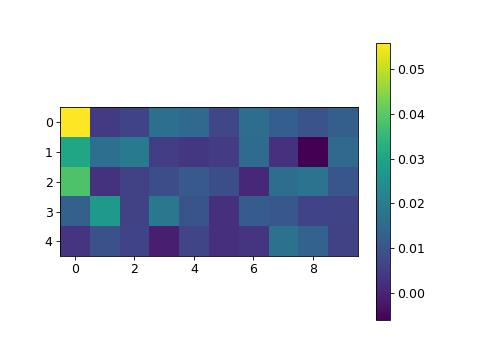

In [30]:
rid=39
tm = trialmeans.groupby(['config']).mean()[rid].reshape(10,5).T
pl.figure()
pl.imshow(tm)
pl.colorbar()

#### For single rid, look at variabiltiy of activity

In [591]:
datakey = '20190522_JC084_fov1'

In [593]:
trial_means = MEANS[datakey]
#binned_traces = BINNED[datakey] # shape: (ntrials_total, nrois_total)

obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
sizes = sorted(sdf['size'].unique())
morphlevels = sorted(sdf['morphlevel'].unique())
               
config_array = np.reshape(sdf.index.tolist(), (10, 5))

Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static


In [72]:
s_ons = bindict['stim_onsets']
stim_on = float(s_ons[s_ons['datakey']==datakey]['stim_on'])
n_on = int(round((bindict['params']['n_frames_on']/bindict['params']['framerate']) * bindict['params']['ds_framerate']))

print(stim_on, n_on)

(4.0, 4)


In [50]:
rid = 17

<IPython.core.display.Javascript object>


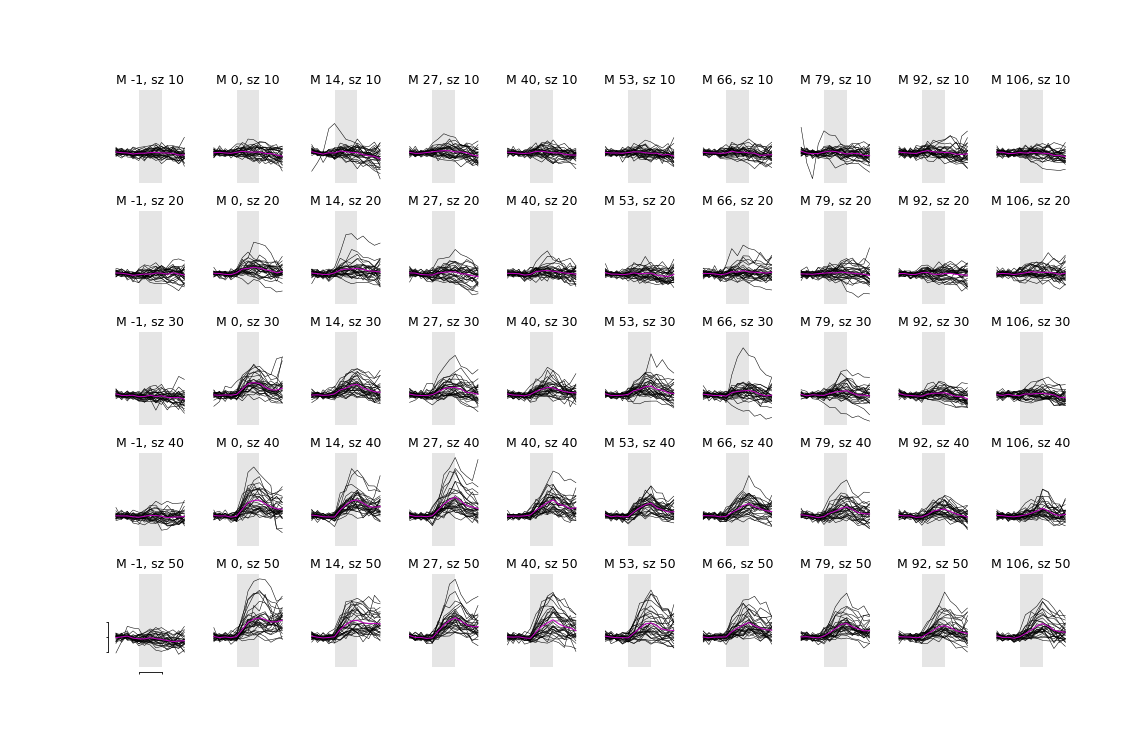

(4, 0)


In [122]:
stim_color = 'gray'
stim_alpha=0.2

fig, axn = pl.subplots(config_array.shape[1], config_array.shape[0], figsize=(15,10), sharex=True, sharey=True)
for cfg, cfg_traces in binned_traces.groupby(['config']): #.ravel()):
        
    morphlevel = sdf['morphlevel'][cfg]
    size = sdf['size'][cfg]
    title_str = 'M %i, sz %i' % (morphlevel, size)
    ri = sizes.index(size)
    ci = morphlevels.index(morphlevel)
    ax = axn[ri, ci]
    ax.set_title(title_str)
    
    n_frames = len(sorted(cfg_traces['frame_ix'].unique()))
    n_trials = len(sorted(cfg_traces['trial'].unique()))
    tmat = np.reshape(cfg_traces[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
    t_df = pd.DataFrame(data=tmat.T, columns=sorted(cfg_traces['trial'].unique()), index=sorted(cfg_traces['frame_ix'].unique()))
    
    for tr in t_df:
        ax.plot(t_df[tr].values.T, 'k', lw=0.5)

    ax.plot(tmat.mean(axis=0), lw=1, color='m')
    if ci>0 or ri!=4:
        sns.despine(bottom=True, left=True, ax=ax)
        ax.tick_params(axis='both', which='both', size=0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_xticks([stim_on, stim_on+n_on])
        ax.set_xticklabels(['', '%i s' % int(round(stim_on/bindict['params']['ds_framerate']))])
        sns.despine(offset=4, trim=True, ax=ax)
        print(ri, ci)
        ax.tick_params(axis='both', which='both', size=2, labelsize=16)
ymin, ymax = ax.get_ylim()
for ax in axn.flat:
    ax.add_patch(mpl.patches.Rectangle((stim_on, ymin), n_on, (ymax-ymin), linewidth=0,
                                 fill=True, color=stim_color, alpha=stim_alpha))
pl.subplots_adjust(wspace=0.3, hspace=0.3, left=0.1, right=0.95)

pl.suptitle("Cell %i" % int(rid+1))


# Calculate variability (non-scaled fano factor)
#### Fano = (std**2 x c**2)/(mean*c).  
This only works if c=1 (scaling of F.R.), since larger F.R. disproportionally affects variance than mean 
#### Adjusted fano = (std_x**2/std_y**2) / (mean_x**2/mean_y**2), 
where we express mean and variance in terms of fractional changes in activity and variability from y to x.

In [605]:
variance_x_reps = trial_means.groupby(['config']).std()**2.
means_x_reps = trial_means.groupby(['config']).mean()

trial_bas = BAS[datakey]
variance_x_reps_bas = trial_bas.groupby(['config']).std()**2.
means_x_reps_bas = trial_bas.groupby(['config']).mean()


d1 = variance_x_reps.unstack().reset_index().rename(columns={0: 'variance', 'level_0': 'rid'}).reset_index(drop=True)
d2 = means_x_reps.unstack().reset_index().rename(columns={0: 'mean', 'level_0': 'rid'}).reset_index(drop=True)

d1_y = variance_x_reps_bas.unstack().reset_index().rename(columns={0: 'variance_bas', 'level_0': 'rid'}).reset_index(drop=True)
d2_y = means_x_reps_bas.unstack().reset_index().rename(columns={0: 'mean_bas', 'level_0': 'rid'}).reset_index(drop=True)

d1['rel_var'] = d1['variance'].values/d1_y['variance_bas'].values
d2['rel_mean'] = d2['mean'].values/d2_y['mean_bas'].values

vardf = pd.merge(d1, d2)



In [610]:
d2.head()

,rid,config,mean,rel_mean
0,1,config001,0.013999,-6.837619e+14
1,1,config002,0.005063,3.084129e+14
2,1,config003,0.009351,-4.711741e+14
3,1,config004,0.007600,-2.111296e+14
4,1,config005,0.007256,1.349795e+15


In [620]:
d2_y['mean_bas'].max()

8.4000450628207301e-17

<IPython.core.display.Javascript object>


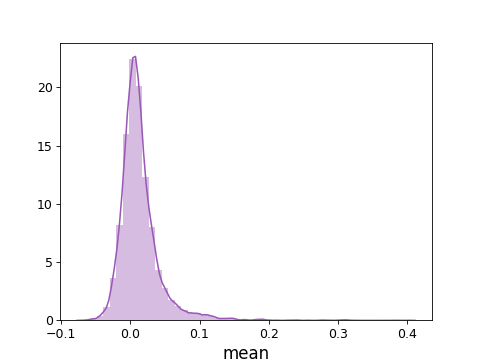

In [618]:
pl.figure()
sns.distplot(d2['mean'])
#sns.distplot(d2_y['mean_bas'])


<IPython.core.display.Javascript object>


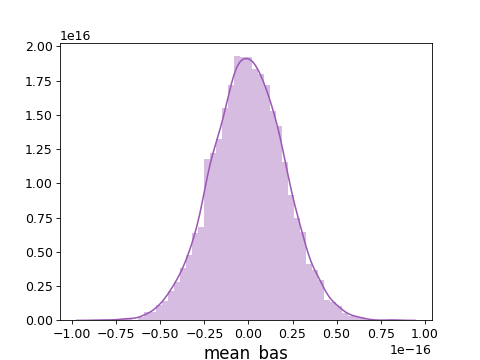

In [615]:
pl.figure()
sns.distplot(d2_y['mean_bas'])
#sns.distplot(d2['mean'])

<IPython.core.display.Javascript object>


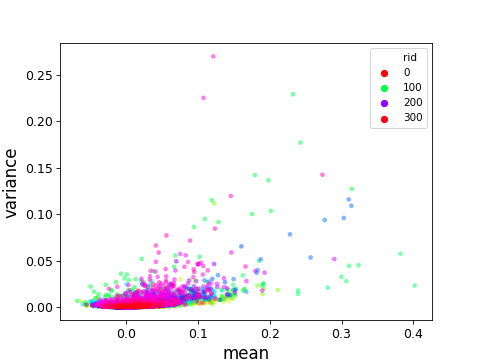

In [606]:
fig, ax = pl.subplots()
sns.scatterplot(x='mean', y='variance', hue='rid', palette='hsv', data=vardf, ax=ax,
               marker='o', s=20, edgecolor='none', alpha=0.5)

<IPython.core.display.Javascript object>


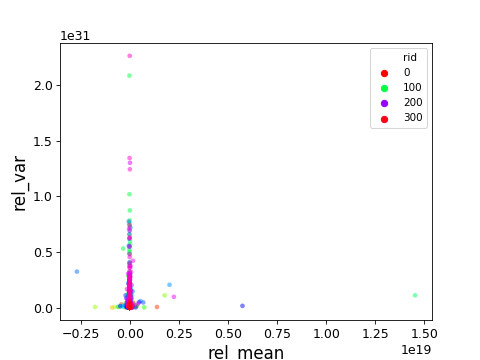

In [607]:
fig, ax = pl.subplots()
sns.scatterplot(x='rel_mean', y='rel_var', hue='rid', palette='hsv', data=vardf, ax=ax,
               marker='o', s=20, edgecolor='none', alpha=0.5)



# Downsample, calculate activity correlations

In [23]:
# Temporal binning params
n_frames_bin = 11.
framerate = 44.65
new_framerate = framerate/n_frames_bin
print("Downsampled fr: %.2f Hz" % new_framerate)

# Pupil alignment params
#pre_ITI_ms=500
#post_ITI_ms=500 #pre_ITI_ms
#epoch='trial_alignment'

#### Get indices of trial epochs to model
#pre_flank = round((pre_ITI_ms/1E3)*44.65) #n_on/2.
#post_flank = round((post_ITI_ms/1E3)*44.65)  #n_on


Downsampled fr: 4.06 Hz


## Test w/ 1 fov

<IPython.core.display.Javascript object>


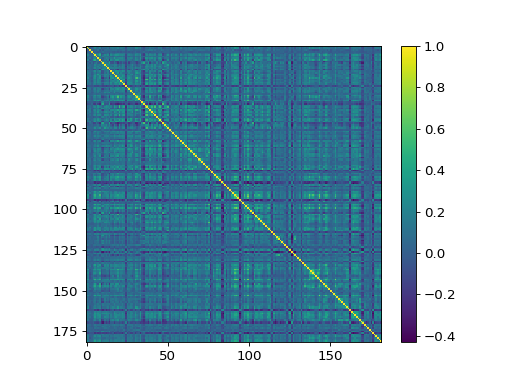

In [216]:
pl.figure()
pl.imshow(binned_traces[roi_list].corr())
pl.colorbar()

#### Check traces

In [205]:
rid = 5 #39 #roi_list[0]

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]


#### Bin traces - Each tbin is a column, each row is a sample 
sample_data = trialmat.fillna(method='pad').copy()
binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
r_['config'] = cfg_list


In [206]:
# Check with known config, known RID
ml=53 #-1
sz=10
print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])

          color morphlevel   object  size stimtype xpos ypos yrot
config026               53  morph53  10.0    image   20   -8    0


<IPython.core.display.Javascript object>


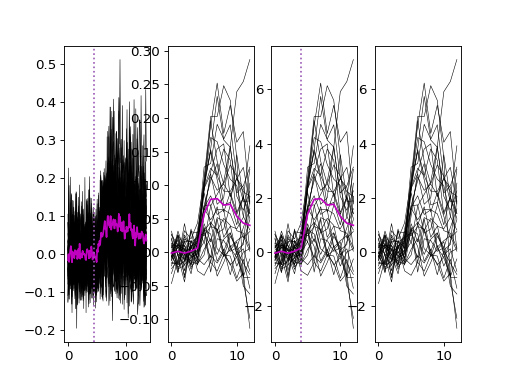

In [208]:
fig, axn = pl.subplots(1, 4)
ax=axn[0]
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm')
ax.axvline(x=stim_on, ls=':')

ax=axn[1]
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm')

ax=axn[2]
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm')
ax.axvline(x=new_stim_on, ls=':')

ax=axn[3]
for tr, g in df[df['config']==cfg].groupby(['trial']):
    ax.plot(g[rid].values.T, 'k', lw=0.5)


# Filter bad fovs

In [830]:
def add_metadata(cc, vardict):
    nvals = cc.shape[0]
    for k, v in vardict.items():
        cc[k] = [v for _ in np.arange(0, nvals)]
    return cc

In [831]:
min_ncells=30
few_cells = []
for datakey, f in MEANS.items():
    print(datakey, f.shape)
    if f.shape[1] < min_ncells:
        few_cells.append(datakey)

('20190512_JC083_fov1', (1575, 115))
('20190420_JC076_fov1', (1500, 46))
('20190603_JC080_fov1', (1500, 121))
('20190506_JC080_fov1', (1450, 148))
('20190510_JC083_fov1', (1750, 76))
('20190422_JC076_fov1', (1500, 80))
('20191111_JC120_fov1', (1500, 41))
('20190517_JC083_fov1', (1250, 79))
('20190613_JC097_fov1', (1500, 121))
('20191018_JC113_fov1', (2350, 54))
('20190622_JC085_fov1', (1500, 226))
('20190501_JC076_fov1', (1500, 41))
('20191008_JC091_fov1', (3150, 125))
('20190504_JC078_fov1', (1500, 88))
('20190606_JC091_fov1', (1625, 111))
('20190605_JC090_fov1', (1635, 142))
('20191105_JC117_fov1', (1350, 76))
('20190618_JC097_fov1', (1500, 53))
('20190602_JC091_fov1', (1499, 162))
('20190507_JC083_fov1', (1500, 98))
('20190614_JC091_fov1', (1500, 133))
('20190616_JC097_fov1', (1500, 186))
('20190508_JC083_fov1', (1465, 123))
('20190612_JC099_fov1', (1500, 66))
('20190609_JC099_fov1', (1500, 63))
('20190617_JC097_fov1', (1475, 179))
('20190511_JC083_fov1', (1500, 91))
('20190509_JC07

In [832]:
excl = copy.copy(few_cells)
bad_targeting = ['20190605_JC090_fov1', '20191008_JC091_fov1']
excl.extend(bad_targeting)

In [833]:
excl

['20190617_JC099_fov1', '20190605_JC090_fov1', '20191008_JC091_fov1']

## Calculate cross-cell correlations (trial means)

In [834]:
missing_data=[]
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    dict_key = '%s_%s' % (session, animalid)
#     if dict_key not in blobmeta[visual_area]:
#         print("[%s] skipping %s" % (visual_area, dict_key))
#         continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print("[%s] missing %s" % (visual_area, datakey))
        missing_data.append(datakey)
        continue

    trialmeans = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    roi_list = np.array([r for r in trialmeans.columns if putils.isnumber(r)]) 
    
    # Get across-cell correlations by trial ('row' and 'col' are pairs of trials)
    cc = melt_square_matrix(trialmeans[roi_list].corr(), metric_name='corrcoef', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    
    x_list.append(cc)

xcell_corrs = pd.concat(x_list, axis=0)
print(xcell_corrs.shape)
#print(missing_data)


(212286, 8)


In [835]:
mean_xcell_coors = xcell_corrs[~xcell_corrs['datakey'].isin(excl)].groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


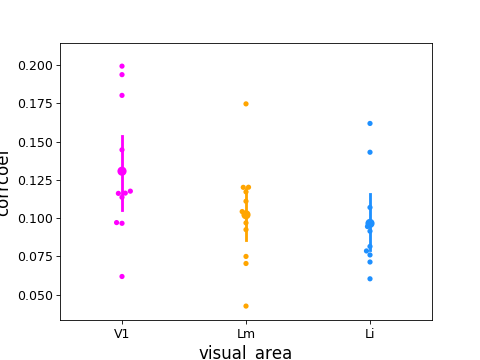

In [836]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_xcell_coors, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_xcell_coors, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


In [573]:
binned_traces.head()

,0,4,6,13,17,22,24,25,28,29,...,246,249,258,259,260,261,269,config,frame_ix,trial
0,-1.104270,0.240751,-0.468921,-0.167526,0.557166,-0.933853,0.029345,-0.746620,-0.716157,-0.544130,...,1.289263,-0.089074,0.393469,-0.328581,0.307535,1.601986,-0.748826,config025,-0.0,1
1,-0.325134,0.072006,0.140294,-0.216715,-0.461357,0.518616,-0.150089,-0.172219,-1.433950,-0.532226,...,-0.844529,0.829409,-0.941574,-0.002574,-0.262393,0.388382,0.540471,config025,1.0,1
2,0.824253,1.008800,-0.477036,1.190722,-0.113374,-0.751919,-0.067395,0.004333,1.759692,0.701984,...,-0.053214,-0.833590,0.442849,0.611521,0.268956,-0.413070,0.267265,config025,2.0,1
3,0.406172,-0.835128,1.106552,-0.815701,0.027234,0.971520,0.037839,0.944585,0.422795,0.470887,...,-0.395428,0.308259,0.049068,-0.097602,-0.221871,-1.451238,0.073141,config025,3.0,1
4,0.618550,1.022778,2.057574,0.039428,-0.186877,-0.213633,0.924704,1.856798,0.320492,0.112542,...,-0.645605,0.130550,2.661935,2.217748,-0.633607,1.429947,0.408620,config025,4.0,1


## Calculate cross-cell correlations, trial activity

In [36]:

x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    dict_key = '%s_%s' % (session, animalid)
#     if dict_key not in blobmeta[visual_area]:
#         print("[%s] skipping %s" % (visual_area, dict_key))
#         continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in BINNED.keys():
        continue

    binned_traces = BINNED[datakey] # shape: (ntrials_total, nrois_total)
    roi_list = np.array([r for r in binned_traces.columns if putils.isnumber(r)]) #r!='config'])
    
    # Get across-cell correlations by trial ('row' and 'col' are pairs of trials)
    cc = melt_square_matrix(binned_traces[roi_list].corr(), metric_name='corrcoef', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    
    x_list.append(cc)

activity_corrs = pd.concat(x_list, axis=0)
print(activity_corrs.shape)


(312253, 8)
['20190502_JC076_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1', '20191008_JC091_fov1', '20190609_JC099_fov1', '20190430_JC078_fov1', '20190504_JC078_fov1', '20190509_JC078_fov1', '20190506_JC080_fov1', '20190508_JC083_fov1', '20190517_JC083_fov1', '20190420_JC076_fov1', '20190501_JC076_fov1', '20190507_JC083_fov1', '20190510_JC083_fov1']


In [37]:
#excl = [] #['20190617_JC099_fov1', '20191111_JC120_fov1']
mean_activity_corrs = activity_corrs[~activity_corrs['datakey'].isin(excl)].groupby(['visual_area', 'datakey']).mean().reset_index()


<IPython.core.display.Javascript object>


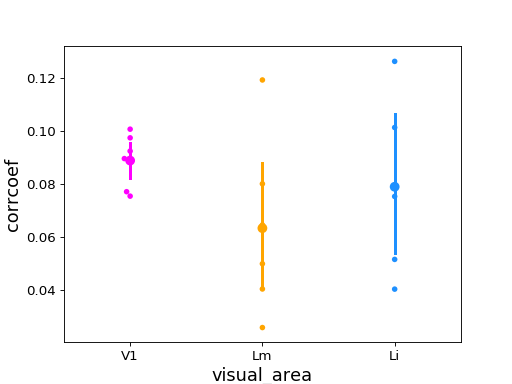

In [38]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_activity_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_activity_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


In [39]:
aggr.do_mannwhitney(mean_xcell_coors, metric='corrcoef')

[('V1', 'Lm')] p=0.151 (holm), reject H0=False
[('V1', 'Li')] p=0.417 (holm), reject H0=False
[('Lm', 'Li')] p=0.417 (holm), reject H0=False


[(('V1', 'Lm'), False, 0.15061874097915426),
 (('V1', 'Li'), False, 0.41679281184762706),
 (('Lm', 'Li'), False, 0.41679281184762706)]

In [40]:
aggr.do_mannwhitney(xcell_corrs, metric='corrcoef')

[('V1', 'Lm')] p=0.000 (holm), reject H0=True
[('V1', 'Li')] p=0.000 (holm), reject H0=True
[('Lm', 'Li')] p=0.000 (holm), reject H0=True


[(('V1', 'Lm'), True, 0.0),
 (('V1', 'Li'), True, 2.8330247511713111e-228),
 (('Lm', 'Li'), True, 3.4356315067362119e-310)]

## Calculate cross-trial corrs

In [45]:
#missing_data=[]
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    dict_key = '%s_%s' % (session, animalid)
#     if dict_key not in blobmeta[visual_area]:
#         print("[%s] skipping %s" % (visual_area, dict_key))
#         continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] missing %s" % (visual_area, datakey))
        #missing_data.append(datakey)
        continue

    trialmeans = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    roi_list = np.array([r for r in trialmeans.columns if putils.isnumber(r)]) 
    
    # Get across-trial correlations by trial ('row' and 'col' are pairs of trials)
    cc = melt_square_matrix(trialmeans[roi_list].T.corr(), metric_name='corrcoef', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    
    x_list.append(cc)

xtrial_corrs = pd.concat(x_list, axis=0)
print(xtrial_corrs.shape)
#print(missing_data)


(24908724, 8)


In [46]:
mean_xtrial_corrs = xtrial_corrs[~xtrial_corrs['datakey'].isin(excl)].groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


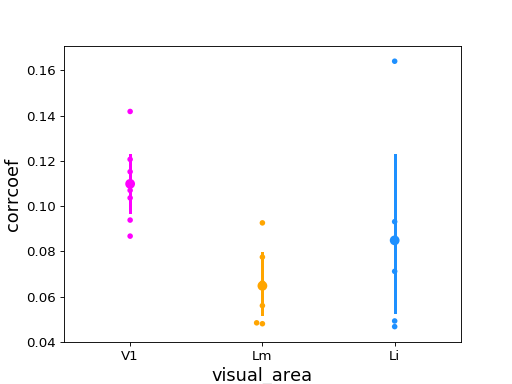

In [47]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_xtrial_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_xtrial_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


## Trial-to-trial correlations for each cell

In [48]:
animalid = 'JC084
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

binned_traces = BINNED[datakey] # shape: (ntrials_total, nrois_total)


obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

n_frames = len(sorted(binned_traces['frame_ix'].unique()))
n_trials = len(sorted(binned_traces['trial'].unique()))
print(n_frames, n_trials)

config_array = np.reshape(sdf.index.tolist(), (10, 5))


In [101]:
tmat.shape

(30, 13)

<IPython.core.display.Javascript object>


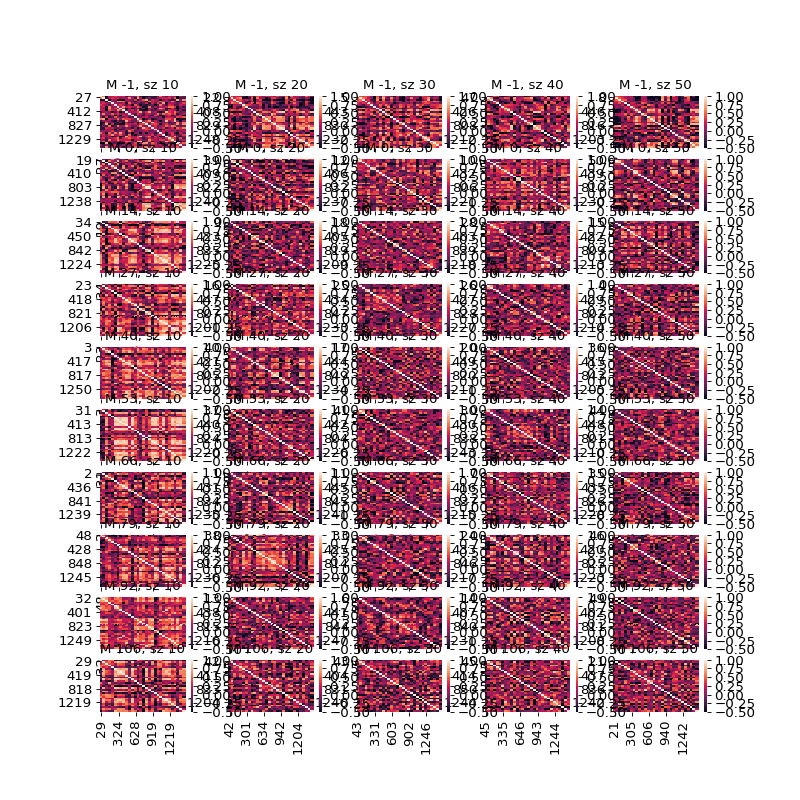

In [102]:


# cc_list = []
# fig, axn = pl.subplots(config_array.shape[0], config_array.shape[1], figsize=(10,10))
# for ax, cfg in zip(axn.flat, config_array.ravel()):
#     morphlevel = sdf['morphlevel'][cfg]
#     size = sdf['size'][cfg]
#     title_str = 'M %i, sz %i' % (morphlevel, size)
#     ax.set_title(title_str)
#     tr = binned_traces[binned_traces['config']==cfg] 
#     tmat = np.reshape(tr[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
#     t_df = pd.DataFrame(data=tmat.T, columns=sorted(tr['trial'].unique()), index=sorted(tr['frame_ix'].unique()))
    
#     cc = melt_square_matrix(t_df.corr(), metric_name='corrcoef', include_diagonal=False)
#     cc['config'] = [cfg for _ in np.arange(0, cc.shape[0])]
#     cc_list.append(cc)
    
#     sns.heatmap(t_df.corr(), ax=ax, vmin=-0.5, vmax=1.0)
    

In [123]:
binned_traces.head()

,1,2,5,6,7,9,10,11,12,14,...,243,245,246,249,251,255,258,config,frame_ix,trial
0,1.427362,0.142272,0.184416,-0.402909,-1.290077,-0.307582,0.033549,-0.107203,0.296352,0.594323,...,0.132575,-0.680102,0.669116,0.668401,-0.652988,0.111374,-0.132679,config032,-0.0,1
1,-0.056254,-0.700513,0.417106,1.321581,0.087162,-0.323059,0.005261,0.577349,-0.362820,0.437404,...,1.615885,-0.268813,0.464228,-0.080755,0.274998,-0.428206,0.359121,config032,1.0,1
2,-0.675176,0.730704,-0.490220,-0.205744,0.182782,-0.026686,0.795037,-0.403678,0.008165,-0.216715,...,-1.818583,0.229261,-0.932626,-0.720344,0.448792,0.776866,0.411194,config032,2.0,1
3,-0.362193,-0.133808,-0.078889,-0.566045,0.685913,0.640618,-0.742506,-0.219362,-0.159651,-0.684630,...,0.220674,0.528405,-0.412144,-0.046739,-0.082468,-0.401760,-0.487119,config032,3.0,1
4,-1.023217,-0.050785,-0.267804,-0.355633,0.512487,0.370633,1.236171,1.322756,0.513791,0.611006,...,-0.995413,-2.066888,0.747665,0.844226,-0.650700,-0.198234,2.521133,config032,4.0,1


In [128]:
t_list=[]
roi_list = [r for r in binned_traces.columns if putils.isnumber(r)]
for rid in roi_list:
    cc_list = []
    for cfg in config_array.ravel():
        tr = binned_traces[binned_traces['config']==cfg]
        tmat = np.reshape(tr[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
        t_df = pd.DataFrame(data=tmat.T, columns=sorted(tr['trial'].unique()), index=sorted(tr['frame_ix'].unique()))

        cc = melt_square_matrix(t_df.corr(), metric_name='corrcoef', include_diagonal=False)
        cc['config'] = [cfg for _ in np.arange(0, cc.shape[0])]
        cc_list.append(cc)

    trialcorrs_by_cond = pd.concat(cc_list, axis=0)
    mean_trialcorrs_by_cond = trialcorrs_by_cond.groupby(['config']).mean()

    mean_trialcorrs_by_cond['rid'] = [rid for _ in np.arange(0, len(mean_trialcorrs_by_cond))]

    t_list.append(mean_trialcorrs_by_cond[['corrcoef', 'rid']].reset_index())


In [130]:
roi_trialcorrs = pd.concat(t_list,axis=0).reset_index(drop=True)
roi_trialcorrs.head()

,config,corrcoef,rid
0,config001,0.179017,1
1,config002,0.109830,1
2,config003,0.154946,1
3,config004,0.056117,1
4,config005,0.037183,1


In [ ]:
fig, axn = pl.subplots(config_array.shape[0], config_array.shape[1], figsize=(10,10))
for ax, cfg in zip(axn.flat, config_array.ravel()):
    morphlevel = sdf['morphlevel'][cfg]
    size = sdf['size'][cfg]
    title_str = 'M %i, sz %i' % (morphlevel, size)
    ax.set_title(title_str)
    sns.stripplot(x='rid', hue='rid', y='corrcoef', data=roi_trialcorrs[roi_trialcorrs['config']==cfg], ax=ax,
                 palette='hsv', dodge=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


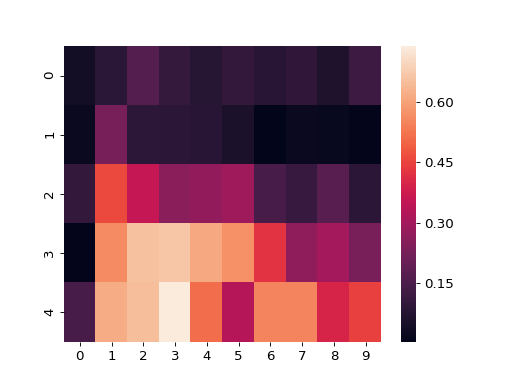

In [114]:
mean_arr = np.reshape(mean_trialcorrs_by_cond['corrcoef'].values,  (10, 5))
pl.figure()
sns.heatmap(mean_arr.T)

# Signal correlations
Index of similarity b w pairs of neurons in mean response to different stimulus types.

In [837]:
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trialmeans = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    #roi_list = np.array([r for r in trialmeans.columns if r!='config'])
    tuning_ = trialmeans.groupby(['config']).mean().reset_index()
    cc = melt_square_matrix(tuning_.corr(), metric_name='corrcoef', include_diagonal=False)
    
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    x_list.append(cc)

signal_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)
    

In [838]:
mean_signal_corrs = signal_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


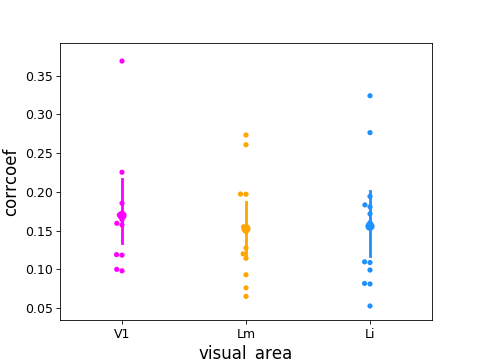

In [839]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_signal_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_signal_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


# Noise correlations
#### Similarity in trial-by-trial repsonse variability between neurons
Calculate response vector for each stimulus type (each element in vector is reposnse to trial i of stimulus cond)
Take mean noise corr. over all stimulus types

In [840]:
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trialmeans = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    # Calculate noise corr for all cell pairs for a given stim condition
    # ncorrs[(ncorrs['row']==0) & (ncorrs['col']==1)] # noise corrs for all conditions for neuron i, j (i=0, j=1)
    ncorrs = pd.concat([melt_square_matrix(resp.corr(), metric_name='corrcoef', 
                                           add_values={'config': cfg}, include_diagonal=False) 
                        for cfg, resp in trialmeans.groupby(['config'])], axis=0)
    # Get mean noise corr over all stim conds for each pair
    cc = ncorrs.groupby(['row', 'col']).mean().reset_index()

    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    x_list.append(cc)

noise_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)
  

In [841]:
noise_corrs.shape, signal_corrs.shape

((212286, 8), (212286, 8))

In [842]:
mean_noise_corrs = noise_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


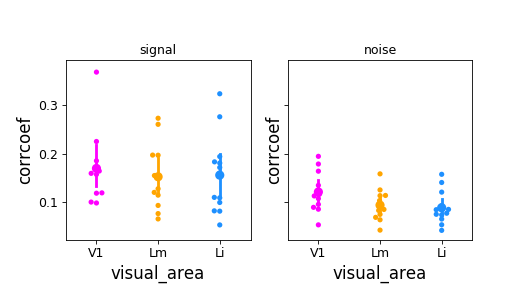

In [843]:
fig, axn = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(7,4))
ax = axn[0]
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_signal_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_signal_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)
ax.set_title('signal')

ax = axn[1]
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_noise_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_noise_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)
ax.set_title('noise')

pl.subplots_adjust(bottom=0.2, top=0.8)


## ... by distance

In [844]:
import scipy.spatial as spatial
from pipeline.python.rois.utils import load_roi_coords

In [344]:
r_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] skipping %s" % (visual_area, datakey))
        continue
        
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)
    cc = fcoords['roi_positions'].copy()
    nvals = cc.shape[0]
    cc['animalid'] = [animalid for _ in np.arange(0, nvals)]
    cc['session'] = [session for _ in np.arange(0, nvals)]
    cc['fovnum'] = [fovnum for _ in np.arange(0, nvals)]
    cc['visual_area'] = [visual_area for _ in np.arange(0, nvals)]
    cc['datakey'] = [datakey for _ in np.arange(0, nvals)]
    
    r_list.append(cc)
    
roi_positions = pd.concat(r_list, axis=0)

... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


In [845]:
import math
def fastdist(v1, v2):
    dist = [(a - b)**2 for a, b in zip(v1, v2)]
    dist = math.sqrt(sum(dist))
    return dist

In [846]:
datakeys = signal_corrs['datakey'].unique()
roipos = roi_positions[roi_positions['datakey'].isin(datakeys)]


In [847]:

signal_corrs['distance'] = ''
noise_corrs['distance'] = ''

for di, (datakey, curr_ccs) in enumerate(signal_corrs.groupby(['datakey'])):
    if di%5==0:
        print('%i of %i dsets' % (int(di+1), len(datakeys)))

    curr_rids = sorted(np.union1d(curr_ccs['row'].unique(), curr_ccs['col'].unique()))
    
    # Coords of all cells, in order
    coords1 = roipos[roipos['datakey']==datakey].loc[curr_rids][['ml_pos', 'ap_pos']]
    
    # Pw distances
    dists = spatial.distance.cdist(coords1, coords1)
    
    # Melt
    d_df = melt_square_matrix(pd.DataFrame(dists, columns=curr_rids, index=curr_rids), 
                              metric_name='distance', include_diagonal=False)


    # coords of cell2 in pair 
    #coords2 = np.array(roipos[roipos['datakey']==datakey].loc[curr_ccs['col'].values][['ml_pos', 'ap_pos']])

    # get dists, in order of appearance
    #dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    #combined = pd.merge(curr_ccs.reset_index(drop=True), d_df)
    
    signal_corrs['distance'][curr_ccs.index] = d_df['distance'].values
    noise_corrs['distance'][curr_ccs.index] = d_df['distance'].values


1 of 36 dsets
6 of 36 dsets
11 of 36 dsets
16 of 36 dsets
21 of 36 dsets
26 of 36 dsets
31 of 36 dsets
36 of 36 dsets


In [848]:
excl.append('20190627_JC091_fov1')
print(excl)

['20190617_JC099_fov1', '20190605_JC090_fov1', '20191008_JC091_fov1', '20190627_JC091_fov1']


In [758]:
excl.append('20190627_JC091_fov1')
print(excl)

['20191111_JC120_fov1', '20190617_JC099_fov1', '20190605_JC090_fov1', '20191008_JC091_fov1', '20190627_JC091_fov1', '20190627_JC091_fov1']


In [849]:
dictkeys = [d for d in list(itertools.chain(*blobmeta.values())) if d not in excl]

dkeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in incl_dictkeys]

incl = [d for d in dkeys if d not in excl]

In [850]:
blobmeta

{'Li': ['20190605_JC090',
  '20190617_JC099',
  '20191018_JC113',
  '20191105_JC117',
  '20191111_JC120',
  '20190602_JC091',
  '20190606_JC091',
  '20190609_JC099',
  '20190502_JC076'],
 'Lm': ['20190525_JC084',
  '20190627_JC091',
  '20190618_JC097',
  '20190512_JC083',
  '20190504_JC078',
  '20190430_JC078',
  '20190506_JC080',
  '20190508_JC083'],
 'V1': ['20190522_JC084',
  '20190622_JC085',
  '20190613_JC097',
  '20190616_JC097',
  '20190617_JC097',
  '20191006_JC110',
  '20190420_JC076',
  '20190507_JC083']}

#### Plot signal corrs v distance

In [851]:
n_bins = 20
use_quartile=True

if use_quartile:
    signal_corrs['binned_dist'] = pd.qcut(signal_corrs['distance'], n_bins, labels=False)
    noise_corrs['binned_dist'] = pd.qcut(noise_corrs['distance'], n_bins, labels=False)
else:
    signal_corrs['binned_dist'] = pd.cut(signal_corrs['distance'], n_bins, labels=False)
    noise_corrs['binned_dist'] = pd.cut(noise_corrs['distance'], n_bins, labels=False)

#_, bin_sizes = pd.qcut(tuning_corrcoefs['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]


<IPython.core.display.Javascript object>


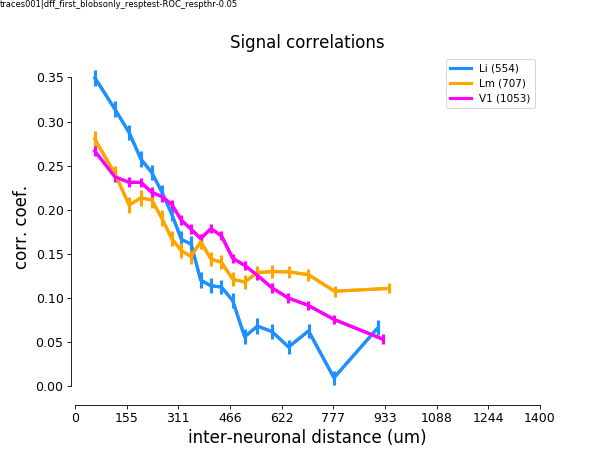

In [852]:
plot_signal = True

if plot_signal:
    plotdf = signal_corrs[signal_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Signal correlations'
else:
    plotdf = noise_corrs[noise_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Noise correlations'
    
fig, ax = pl.subplots(figsize=(8,6))
for visual_area, currdf in plotdf.groupby(['visual_area']):

    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])
    bin_dists = [b_df['distance'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_ccs = [b_df['corrcoef'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in currdf.groupby(['binned_dist'])]    
    
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=area_colors[visual_area], lw=3)
    
    xticks = np.linspace(0, 1400, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels([int(b) for b in xticks])
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')
#ax.set_ylim([0, 0.2])
sns.despine(trim=True, offset=4)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(fig_title, fontsize=16)

putils.label_figure(fig, data_id)

<IPython.core.display.Javascript object>


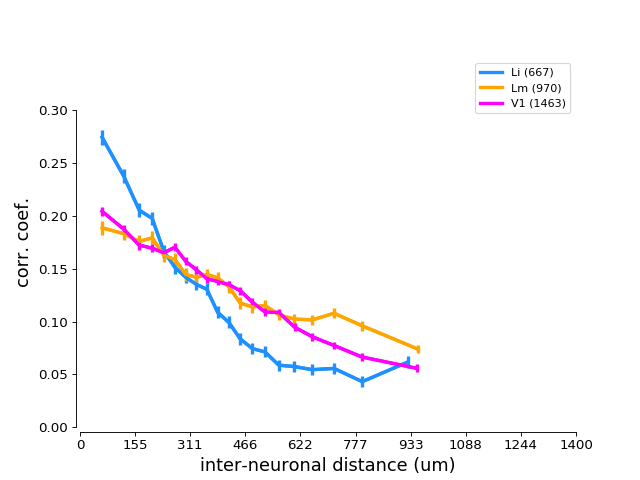

In [541]:

plotdf = signal_corrs[~signal_corrs['datakey'].isin(excl)].copy()

fig, ax = pl.subplots(figsize=(8,6))
for visual_area, currdf in plotdf.groupby(['visual_area']):

    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])
    bin_dists = [b_df['distance'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_ccs = [b_df['corrcoef'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in currdf.groupby(['binned_dist'])]    
    
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=area_colors[visual_area], lw=3)
    
    xticks = np.linspace(0, 1400, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels([int(b) for b in xticks])
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')
ax.set_ylim([0, 0.35])
sns.despine(trim=True, offset=4)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title('Signal correlations', fontsize=16)

label_figure(fig, data_id)


#### Plot noise corrs v distance

<IPython.core.display.Javascript object>


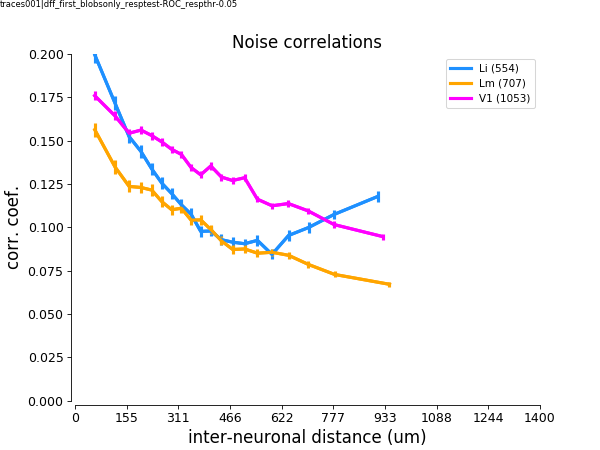

In [853]:
plot_signal = False

if plot_signal:
    plotdf = signal_corrs[signal_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Signal correlations'
else:
    plotdf = noise_corrs[noise_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Noise correlations'
    
fig, ax = pl.subplots(figsize=(8,6))
for visual_area, currdf in plotdf.groupby(['visual_area']):

    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])
    bin_dists = [b_df['distance'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_ccs = [b_df['corrcoef'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in currdf.groupby(['binned_dist'])]    
    
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=area_colors[visual_area], lw=3)
    
    xticks = np.linspace(0, 1400, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels([int(b) for b in xticks])
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')
ax.set_ylim([0, 0.2])
sns.despine(trim=True, offset=4)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(fig_title, fontsize=16)

putils.label_figure(fig, data_id)

#### Split by fov

In [854]:
excl

['20190617_JC099_fov1',
 '20190605_JC090_fov1',
 '20191008_JC091_fov1',
 '20190627_JC091_fov1']

<IPython.core.display.Javascript object>


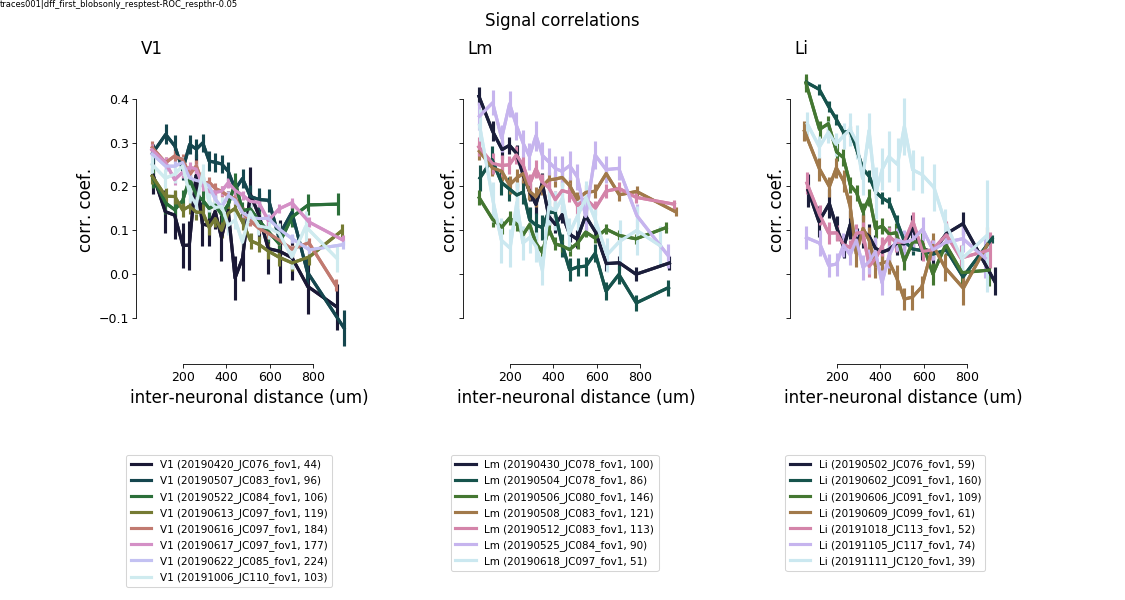

In [855]:
plot_signal = True

if plot_signal:
    plotdf = signal_corrs[signal_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Signal correlations'
else:
    plotdf = noise_corrs[noise_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Noise correlations'
    
fig, axn = pl.subplots(1, 3, figsize=(15,8), sharex=True, sharey=True)
for ax, (visual_area, currdf) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):

    dcolors = sns.color_palette('cubehelix', n_colors=len(currdf['datakey'].unique()))
    
    for dcolor, (dkey, g) in zip(dcolors, currdf.groupby(['datakey'])):

        ncells_t = sum([len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])

        bin_dists = [b_df['distance'].mean() for b, b_df in g.groupby(['binned_dist'])]  
        bin_ccs = [b_df['corrcoef'].mean() for b, b_df in g.groupby(['binned_dist'])]
        bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in g.groupby(['binned_dist'])]    

        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)

        ax.set_xlabel('inter-neuronal distance (um)')
        ax.set_ylabel('corr. coef.')
        
    #ax.set_ylim([0, 0.06])
    sns.despine(trim=True, offset=4, ax=ax)
    ax.legend(bbox_to_anchor=(0.9, -0.3)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    
pl.suptitle(fig_title, fontsize=16)
putils.label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.5, bottom=0.4, top=0.9)


<IPython.core.display.Javascript object>


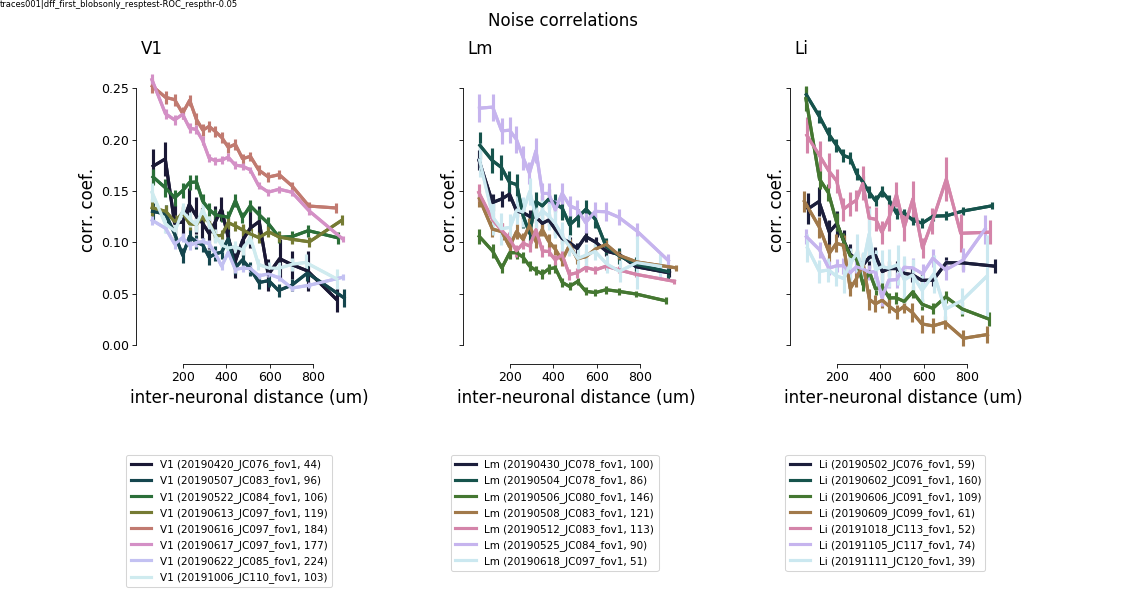

In [856]:
plot_signal = False

if plot_signal:
    plotdf = signal_corrs[signal_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Signal correlations'
else:
    plotdf = noise_corrs[noise_corrs['datakey'].isin(incl)].copy()
    fig_title = 'Noise correlations'
    
fig, axn = pl.subplots(1, 3, figsize=(15,8), sharex=True, sharey=True)
for ax, (visual_area, currdf) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):

    dcolors = sns.color_palette('cubehelix', n_colors=len(currdf['datakey'].unique()))
    
    for dcolor, (dkey, g) in zip(dcolors, currdf.groupby(['datakey'])):

        ncells_t = sum([len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])

        bin_dists = [b_df['distance'].mean() for b, b_df in g.groupby(['binned_dist'])]  
        bin_ccs = [b_df['corrcoef'].mean() for b, b_df in g.groupby(['binned_dist'])]
        bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in g.groupby(['binned_dist'])]    

        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)

        ax.set_xlabel('inter-neuronal distance (um)')
        ax.set_ylabel('corr. coef.')
        
    #ax.set_ylim([0, 0.06])
    sns.despine(trim=True, offset=4, ax=ax)
    ax.legend(bbox_to_anchor=(0.9, -0.3)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    
pl.suptitle(fig_title, fontsize=16)
putils.label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.5, bottom=0.4, top=0.9)


# Corr s a function of ditsance, along Azimuth vs along Elev


In [705]:
tvals = trial_means[rlist].copy()
tvals[tvals<0] = tvals[tvals<0]


trial_means[rlist].subtract(trial_means[rlist].min())


,0,1,2,3,4,5,6,7,8,11,...,354,356,363,364,366,368,382,383,384,390
1,0.555179,0.352647,0.591692,0.403157,0.142647,0.404281,0.401585,0.948858,0.457438,0.525152,...,0.173839,0.100772,0.152993,0.280113,0.256414,0.073422,0.155502,0.188893,0.415376,0.164165
2,0.313474,0.302442,0.260986,0.186265,0.207429,0.259767,0.165352,0.638300,0.144887,0.285610,...,0.139627,0.117848,0.099269,0.268673,0.217924,0.000000,0.096888,0.161045,0.231198,0.133416
3,0.229801,0.009445,0.143012,0.162018,0.174202,0.376380,0.263902,0.407189,0.300618,0.262193,...,0.131368,0.089551,0.091124,0.132172,0.208588,0.083577,0.088855,0.118755,0.249247,0.112636
4,0.323881,0.160990,0.181383,0.119798,0.226419,0.142676,0.160183,0.547885,0.098894,0.196349,...,0.186003,0.064999,0.064689,0.189819,0.081634,0.105342,0.084959,0.190323,0.161663,0.106844
5,0.400595,0.197455,0.243709,0.223304,0.199858,0.322129,0.248284,0.284352,0.266868,0.291234,...,0.131711,0.093569,0.098259,0.183944,0.000000,0.072514,0.134684,0.133837,0.246612,0.104437
6,0.397107,0.022482,0.111996,0.147058,0.202840,0.065671,0.178449,0.135750,0.095572,0.218795,...,0.151544,0.113514,0.150566,0.078090,0.328749,0.116357,0.102863,0.085467,0.166109,0.126195
7,0.575796,0.264715,0.421158,0.280523,0.328749,0.277460,0.262472,0.793357,0.300172,0.399636,...,0.177233,0.107505,0.158594,0.474792,0.064803,0.080844,0.153138,0.167692,0.204949,0.064174
8,0.268992,0.074334,0.100585,0.132018,0.196426,0.105997,0.200939,0.245874,0.087304,0.210746,...,0.111987,0.109171,0.071364,0.050134,0.155697,0.138764,0.163138,0.176213,0.204125,0.111562
9,0.402442,0.223781,0.320233,0.213335,0.293655,0.190387,0.186574,0.493435,0.166331,0.327758,...,0.113927,0.124137,0.263708,0.291582,0.026427,0.106491,0.097272,0.137200,0.231069,0.134307
10,0.447394,0.125688,0.347091,0.273177,0.089887,0.074810,0.194572,0.294705,0.126977,0.189500,...,0.128102,0.114461,0.061415,0.069805,0.059393,0.145591,0.134577,0.145898,0.214664,0.165863


In [873]:
excl.append('20191105_JC117_fov1') # 20191105_JC117_fov1

In [874]:
incl = [d for d in dkeys if d not in excl]

# Variance

In [875]:
use_relative=False

x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trial_means = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    rlist = np.array([r for r in trial_means.columns if putils.isnumber(r)])

    adj = trial_means[rlist].subtract(trial_means[rlist].min())
    trial_means[rlist] = adj.values
    
    if use_relative:
        trial_bas = BAS[datakey]
        adj_b = trial_bas[rlist].subtract(trial_bas[rlist].min())
        trial_bas[rlist] = adj_b.values

    #zs = (trial_means[rlist])/trial_means[rlist].std()

    #variance_x_reps = (trial_means.groupby(['config']).std()**2.) #.reset_index()
    variance_x_reps = trial_means.groupby(['config']).apply(np.var)
    if use_relative:
        variance_x_reps_bas = trial_bas.groupby(['config']).apply(np.var) # (trial_bas.groupby(['config']).std()**2.) 
        relative_var = variance_x_reps.divide(variance_x_reps_bas)
        d1 = relative_var.unstack().reset_index().rename(columns={0: 'variance', 'level_0': 'rid'}).reset_index(drop=True)
    else:
        d1 = variance_x_reps.unstack().reset_index().rename(columns={0: 'variance', 'level_0': 'rid'}).reset_index(drop=True)
    
    means_x_reps = trial_means.groupby(['config']).mean()
    if use_relative:
        means_x_reps_bas = trial_bas.groupby(['config']).mean()
        relative_mean = means_x_reps.divide(means_x_reps_bas)    
        d2 = relative_mean.unstack().reset_index().rename(columns={0: 'mean', 'level_0': 'rid'}).reset_index(drop=True)
    else:
        d2 = means_x_reps.unstack().reset_index().rename(columns={0: 'mean', 'level_0': 'rid'}).reset_index(drop=True)
    vardf = pd.merge(d1, d2)

    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(vardf, metadict)
    x_list.append(cc)

variance = pd.concat(x_list, axis=0).reset_index(drop=True)

In [876]:
plotdf = variance[variance['datakey'].isin(incl)].copy()


<IPython.core.display.Javascript object>


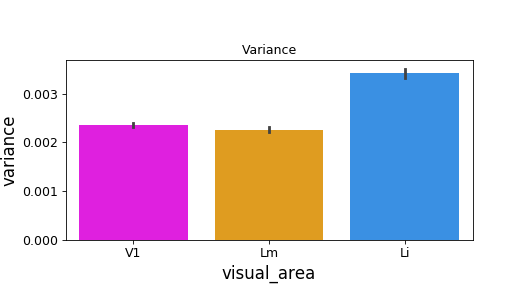

                    rid  variance      mean  fovnum
visual_area                                        
Li           149.804527  0.003419  0.168369     1.0
Lm           139.004202  0.002265  0.146451     1.0
V1           171.432611  0.002356  0.146319     1.0
[('V1', 'Lm')] p=0.000 (holm), reject H0=True
[('V1', 'Li')] p=0.000 (holm), reject H0=True
[('Lm', 'Li')] p=0.000 (holm), reject H0=True


[(('V1', 'Lm'), True, 5.355496693792465e-23),
 (('V1', 'Li'), True, 0.0),
 (('Lm', 'Li'), True, 0.0)]

In [877]:
fig, ax = pl.subplots(sharex=True, sharey=True, figsize=(7,4))
sns.barplot(x='visual_area', y='variance', data=plotdf, ax=ax,
             order=visual_areas, palette=area_colors)
# sns.pointplot(x='visual_area', y='variance', data=plotdf, ax=ax,
#              palette=area_colors, order=visual_areas, join=False)
ax.set_title('Variance')
#ax.set_ylim([0, 1])
pl.subplots_adjust(bottom=0.2, top=0.8)

print(plotdf.groupby(['visual_area']).mean())

aggr.do_mannwhitney(plotdf, metric='variance', multi_comp_test='holm')

<IPython.core.display.Javascript object>


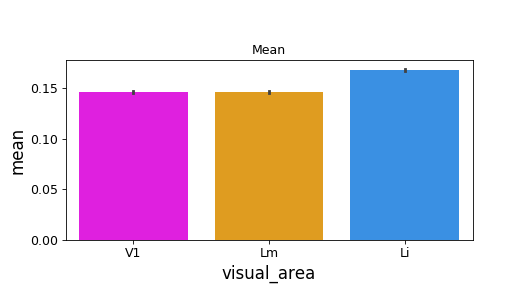

                    rid  variance      mean  fovnum
visual_area                                        
Li           149.804527  0.003419  0.168369     1.0
Lm           139.004202  0.002265  0.146451     1.0
V1           171.432611  0.002356  0.146319     1.0
[('V1', 'Lm')] p=0.000 (fdr_by), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_by), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_by), reject H0=True


[(('V1', 'Lm'), True, 1.4647078713892309e-12),
 (('V1', 'Li'), True, 0.0),
 (('Lm', 'Li'), True, 1.8879018578158427e-268)]

In [878]:
fig, ax = pl.subplots(sharex=True, sharey=True, figsize=(7,4))
sns.barplot(x='visual_area', y='mean', data=plotdf, ax=ax,
             order=visual_areas, palette=area_colors)
# sns.pointplot(x='visual_area', y='variance', data=plotdf, ax=ax,
#              palette=area_colors, order=visual_areas, join=False)
ax.set_title('Mean')
#ax.set_ylim([0, 1])
pl.subplots_adjust(bottom=0.2, top=0.8)

print(plotdf.groupby(['visual_area']).mean())

aggr.do_mannwhitney(plotdf, metric='mean', multi_comp_test='fdr_by')

## means

In [881]:
mean_variance = plotdf.groupby(['visual_area', 'datakey']).mean().reset_index()


In [882]:
mean_variance

,visual_area,datakey,rid,variance,mean,fovnum
0,Li,20190502_JC076_fov1,116.716667,0.002245,0.130468,1.0
1,Li,20190602_JC091_fov1,177.217391,0.003867,0.174183,1.0
2,Li,20190606_JC091_fov1,150.054545,0.003431,0.170033,1.0
3,Li,20190609_JC099_fov1,183.080645,0.002666,0.174095,1.0
4,Li,20191018_JC113_fov1,120.547170,0.001240,0.134394,1.0
5,Li,20191111_JC120_fov1,75.600000,0.007403,0.233385,1.0
6,Lm,20190430_JC078_fov1,139.663366,0.001366,0.123881,1.0
7,Lm,20190504_JC078_fov1,144.528736,0.002438,0.147799,1.0
8,Lm,20190506_JC080_fov1,129.918367,0.002790,0.160792,1.0
9,Lm,20190508_JC083_fov1,128.286885,0.001324,0.119719,1.0


<IPython.core.display.Javascript object>


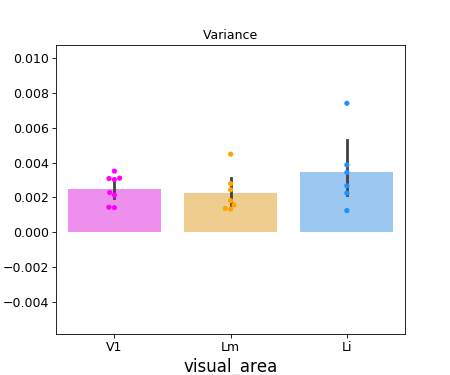

                    rid  variance      mean  fovnum
visual_area                                        
Li           137.202736  0.003475  0.169426     1.0
Lm           136.839766  0.002253  0.145064     1.0
V1           157.535813  0.002497  0.151625     1.0
[('V1', 'Lm')] p=0.530 (holm), reject H0=False
[('V1', 'Li')] p=0.530 (holm), reject H0=False
[('Lm', 'Li')] p=0.530 (holm), reject H0=False


[(('V1', 'Lm'), False, 0.52966685175900841),
 (('V1', 'Li'), False, 0.52966685175900841),
 (('Lm', 'Li'), False, 0.52966685175900841)]

In [884]:
fig, ax = pl.subplots(sharex=True, sharey=True, figsize=(6,5))
sns.swarmplot(x='visual_area', y='variance', data=mean_variance, ax=ax,
             order=visual_areas, palette=area_colors)
sns.barplot(x='visual_area', y='variance', data=mean_variance, ax=ax,
             palette=area_colors, order=visual_areas, alpha=0.5) #, join=False)
ax.set_title('Variance')
#pl.subplots_adjust(bottom=0.2, top=0.8)

print(mean_variance.groupby(['visual_area']).mean())
aggr.do_mannwhitney(mean_variance, metric='variance', multi_comp_test='holm' ) #'fdr_by')

#### stats

In [885]:
aggr.do_mannwhitney(mean_variance, metric='variance', multi_comp_test='holm' ) #'fdr_by')

[('V1', 'Lm')] p=0.530 (holm), reject H0=False
[('V1', 'Li')] p=0.530 (holm), reject H0=False
[('Lm', 'Li')] p=0.530 (holm), reject H0=False


[(('V1', 'Lm'), False, 0.52966685175900841),
 (('V1', 'Li'), False, 0.52966685175900841),
 (('Lm', 'Li'), False, 0.52966685175900841)]

In [886]:
mean_variance.groupby(['visual_area']).mean()

,rid,variance,mean,fovnum
visual_area,,,,
Li,137.202736,0.003475,0.169426,1.0
Lm,136.839766,0.002253,0.145064,1.0
V1,157.535813,0.002497,0.151625,1.0


<IPython.core.display.Javascript object>


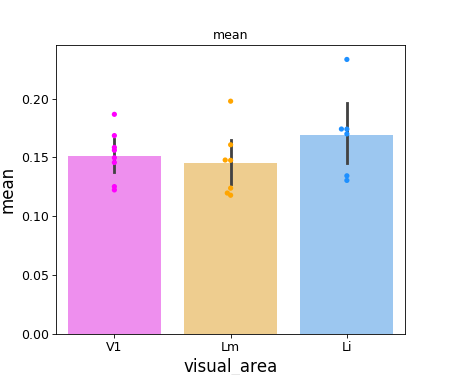

Text(0.5,1,u'mean')

In [888]:
fig, ax = pl.subplots(sharex=True, sharey=True, figsize=(6,5))
sns.swarmplot(x='visual_area', y='mean', data=mean_variance, ax=ax,
             order=visual_areas, palette=area_colors)
sns.barplot(x='visual_area', y='mean', data=mean_variance, ax=ax,
             palette=area_colors, order=visual_areas, alpha=0.5) #, join=False)
ax.set_title('mean')
#pl.subplots_adjust(bottom=0.2, top=0.8)
